# Multiple Coordinated Views

In [21]:
import altair as alt
import pandas as pd
import numpy as np

In [22]:
flu = pd.read_csv('flunet2010_11countries.csv', header=[0,1])
cols = flu.columns.tolist()
normed = pd.melt(flu, id_vars=[cols[0]], value_vars=cols[1:], var_name=['continent','country'])
normed = normed.rename(columns={normed.columns[0]: 'week'})
normed.head()

,week,continent,country,value
0,1,Asia,Afghanistan,5.0
1,2,Asia,Afghanistan,13.0
2,3,Asia,Afghanistan,4.0
3,4,Asia,Afghanistan,0.0
4,5,Asia,Afghanistan,0.0


## Visualization 1
#### Create Linked Plots Showing Flu Cases per Country and Total Flu Cases per Week
In this example a dropdown selector and a time slider provided by the crosstalk package are linked to two plots.

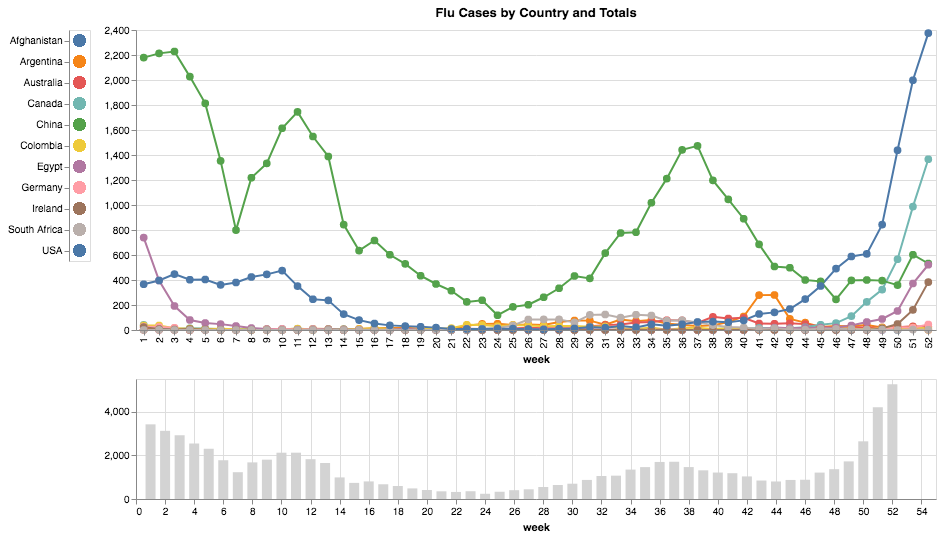

In [28]:
click = alt.selection_multi(encodings=['color'])
brush = alt.selection_interval(encodings=['x'])

line = alt.Chart(normed).mark_line(point=alt.MarkConfig(shape='circle', size=60)).encode(
    x='week:N',
    y=alt.Y('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
    tooltip=['week','value']
).transform_filter(
    brush
).transform_filter(
    click
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=click
)

hist = alt.Chart(normed).mark_bar(size=10).encode(
    x='week',
    y=alt.Y('sum(value):Q', title=None),
    color=alt.value('lightgray'),
    tooltip=['week','sum(value)']
).properties(
    width=800,
    height=120,
).add_selection(
    brush
)

legend = alt.Chart(normed).mark_circle(size=150).encode(
    y=alt.Y('country', title=None),
    color=alt.condition(click, alt.Color('country:N', legend=None), alt.value('lightgray'))
).properties(
    selection=click
)

legend | (line & hist)

#### Selections:
* Click to select individual countries.
* Hold shift and click to select multiple countries.
* Brush barchart to narrow top view.

## Visualization 2
#### Create an Overview+Detail Plot Showing Flu Cases per Country

In this example a checkbox selection is used to control countries of which continents are shown in a stacked bar chart. The stacked bar chart shows flu cases per week and country. The overview+detail visualization is enabled by using the rangeslider property on the x axis of the plot.

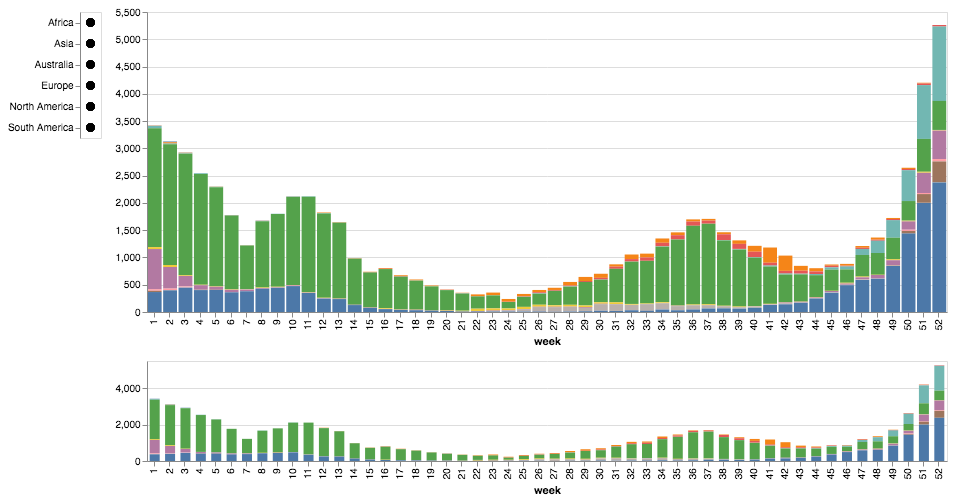

In [90]:
click = alt.selection_multi(encodings=['y'])
brush = alt.selection_interval(encodings=['x'])


bar = alt.Chart(normed).mark_bar().encode(
    alt.Color('country:N', legend=None),
    alt.X('week:N'),
    alt.Y('sum(value)', title=None),
    tooltip=['country']
).transform_filter(
    click
).transform_filter(
    brush
).properties(
    width=800,
)

bar_overview = alt.Chart(normed).mark_bar(size=10).encode(
    alt.X('week:N'),
    alt.Y('sum(value)', title=None),
    alt.Color('country:N', legend=None)
).properties(
    height=100,
    width=800,
    selection=brush
)

legend = alt.Chart(normed).mark_circle(size=60).encode(
    alt.Y('continent:N', title=None),
    color=alt.condition(click, alt.value('black'), alt.value('lightgray'))
).properties(
    selection=click
)

legend | (bar & bar_overview)

## Visualization 3
#### Create Linked Plots Showing Flu Cases per Country per Week and Total Flu Cases per Country
For this visualization we create two linked plots. One that shows flu cases per country per week and a second on that show the total of all flu cases per country.

I created an extra view where you can brush over the line plot and see totals for your selection.

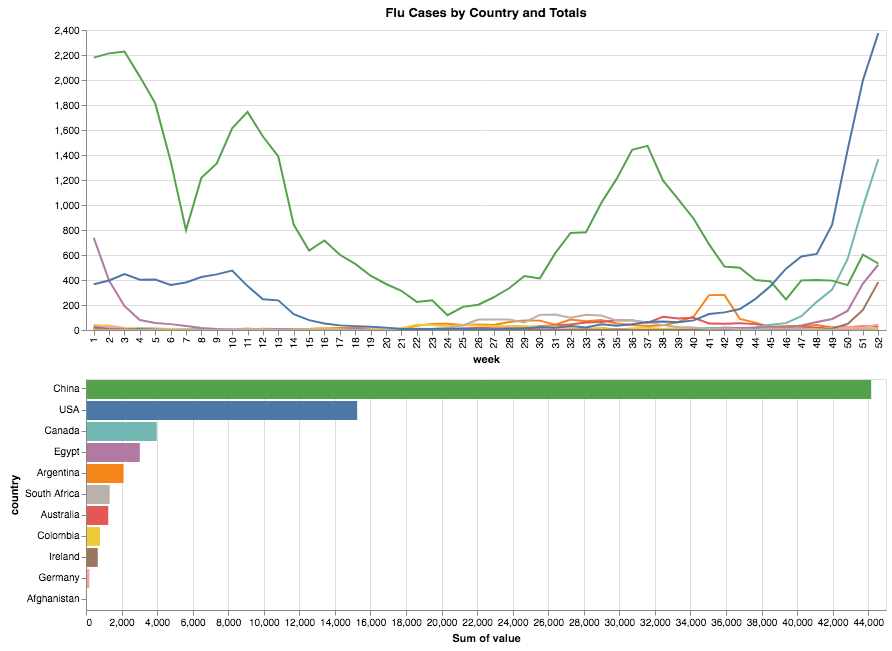

In [24]:
barclick = alt.selection_multi(encodings=['color'])

line = alt.Chart(normed).mark_line().encode(
    x='week:N',
    y=alt.X('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
).transform_filter(
    barclick
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=barclick
)

bar = alt.Chart(normed).mark_bar().encode(
    x='sum(value):Q',
    y=alt.Y('country:N', sort=alt.SortField(field="value", op="sum", order='descending')),
    color=alt.condition(barclick, alt.Color('country:N', legend=None), alt.value('lightgray'))
).properties(
    width=800,
    selection=barclick
)

line & bar

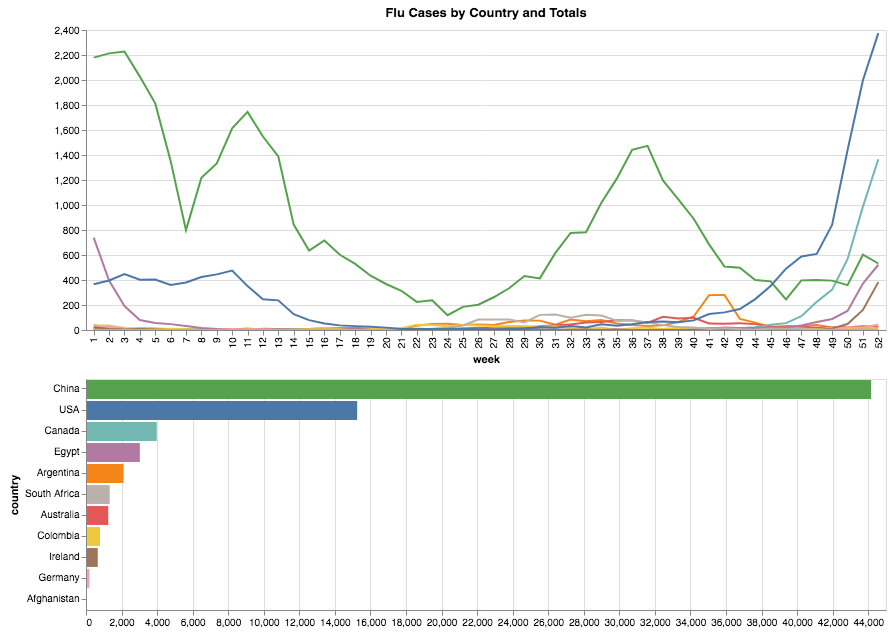

In [25]:
plot_brush = alt.selection_interval(encodings=['x'])

line = alt.Chart(normed).mark_line().encode(
    x='week:N',
    y=alt.X('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=plot_brush
)

bar = alt.Chart(normed).mark_bar().encode(
    x=alt.X('sum(value):Q', title=None),
    y=alt.Y('country:N', sort=alt.SortField(field="value", op="sum", order='descending')),
    color=alt.Color('country:N', legend=None)
).transform_filter(
    plot_brush
).properties(
    width=800,
)

line & bar

In [26]:
flu = pd.read_csv('flunet2010_11countries.csv', header=[0,1])
cols = flu.columns.tolist()
normed = pd.melt(flu, id_vars=[cols[0]], value_vars=cols[1:], var_name=['continent','country'])
normed = normed.rename(columns={normed.columns[0]: 'week'})
normed.head()

,week,continent,country,value
0,1,Asia,Afghanistan,5.0
1,2,Asia,Afghanistan,13.0
2,3,Asia,Afghanistan,4.0
3,4,Asia,Afghanistan,0.0
4,5,Asia,Afghanistan,0.0


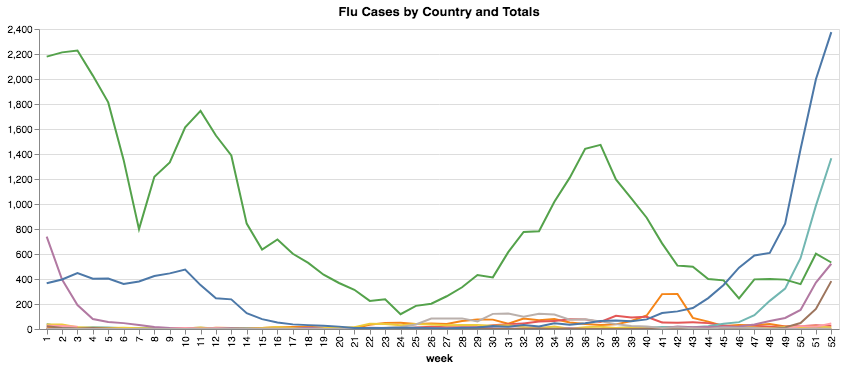

In [27]:
plot_brush = alt.selection_interval(encodings=['x'])

line = alt.Chart(normed).mark_line().encode(
    x='week:N',
    y=alt.X('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=plot_brush
)

line